In [1]:
from utils import *

Test triangulation error with PnP estimated pose matrices when the pixel localizations of the fiducial markers is off by different amounts.

In [2]:
c1 = create_sensor(sensor_number=1)
c2 = create_sensor(sensor_number=2)
c3 = create_sensor(sensor_number=3)

# Extract projection matrices from sensors
c1pose_actual = np.array(c1['to_world'].matrix)[:3,:]
c2pose_actual = np.array(c2['to_world'].matrix)[:3,:]
c3pose_actual = np.array(c3['to_world'].matrix)[:3,:]
actual_poses = np.stack([c1pose_actual, c2pose_actual, c3pose_actual])

inv_actual_poses = compute_inverse_pose_matrices(actual_poses)

print(actual_poses)

[[[-6.56510830e-01 -7.29643881e-01  1.91346124e-01 -5.96334600e+00]
  [-6.56510830e-01  6.77617311e-01  3.31403643e-01 -1.03287039e+01]
  [-3.71466011e-01  9.19492841e-02 -9.23882246e-01  1.78488827e+01]]

 [[ 9.23874855e-01 -8.44208353e-06 -3.82694721e-01  1.19286947e+01]
  [ 0.00000000e+00 -1.00000000e+00  2.20595775e-05 -2.20595775e-05]
  [-3.82694721e-01 -2.03802883e-05 -9.23874855e-01  1.78498745e+01]]

 [[-6.56507790e-01  7.29646504e-01  1.91346720e-01 -5.96384668e+00]
  [ 6.56507790e-01  6.77613378e-01 -3.31417680e-01  1.03296175e+01]
  [-3.71476769e-01 -9.19576734e-02 -9.23877120e-01  1.78518772e+01]]]


In [3]:
# Create default grid for use later
cparams = default_cylindrical_grid_params
grid = generate_cylindrical_grid(**cparams)

In [4]:
# Taken from Blender model:
fiducial_marker_world_posns = [
    [-5.3029,  2.2389, 0.0],
    [-2.2382,  5.3024, 0.0],
    [ 0.0,     0.0,    0.0],
    [ 5.3031, -2.397,  0.0],
    [ 2.2381, -5.305,  0.0],
]

# Project the true positions onto the sensors to determine their true pixel positions
fiducial_marker_pixel_posns = []
for i in range(actual_poses.shape[0]):
    pixel_posns = []
    for posn in fiducial_marker_world_posns:
        pixel_posns.append(normalized_to_pixel(reproject(inv_actual_poses[i], posn)))
    fiducial_marker_pixel_posns.append(pixel_posns)

fiducial_marker_world_posns = np.array(fiducial_marker_world_posns)

# fiducial_marker_pixel_posns = np.array(fiducial_marker_pixel_posns)
print(fiducial_marker_pixel_posns)

[[array([693.08077374, 234.79787765]), array([785.80864277, 250.4641723 ]), array([743.70104588, 374.32511289]), array([790.7866389 , 513.26340696]), array([695.87381797, 514.92703936])], [array([851.42642484, 452.07072778]), array([793.35192924, 529.93646924]), array([746.85254683, 399.9887161 ]), array([619.96503279, 332.33362573]), array([696.41140741, 258.94985674])], [array([615.34741402, 493.44663717]), array([614.80958369, 372.86665814]), array([743.6743427 , 425.66516249]), array([854.19283324, 370.90726213]), array([848.33480539, 468.57413886])]]


In [5]:
# project the points directly onto the image plane using the actual camera poses
actualp1 = []
actualp2 = []
actualp3 = []
inv_actual_poses = compute_inverse_pose_matrices(actual_poses)
for point in grid:
    actualp1.append(normalized_to_pixel(reproject(inv_actual_poses[0], point)))
    actualp2.append(normalized_to_pixel(reproject(inv_actual_poses[1], point)))
    actualp3.append(normalized_to_pixel(reproject(inv_actual_poses[2], point)))
actualp1 = np.array(actualp1)
actualp2 = np.array(actualp2)
actualp3 = np.array(actualp3)

In [6]:
largest_offset_pixels = 5
n = 100 # number of different random max pixel offsets
m = 20 # number of runs per max pixel offset

pose_position_errors = []
pose_rotation_errors = []
average_triangulation_errors = []

# Test n different random max pixel offsets
for i in range(0, n+1):

    max_offset = largest_offset_pixels * i/n

    # Keep track of the errors for this max offset...
    ppe = []
    pre = []
    ate = []

    # For each max pixel offset, do m runs
    for j in range(m):

        # Calculate the pose matrix for each camera
        estimated_poses = []
        k = 0
        for pixel_posns in fiducial_marker_pixel_posns:
            # Apply random offset to pixel positions
            pixel_posns = np.array([p + max_offset*random_in_unit_circle() for p in pixel_posns])

            # Use offset fiducial pixel positions to estimate the pose matrix
            estimated_pose_matrix = estimate_pose_matrix(pixel_posns, fiducial_marker_world_posns)
            estimated_poses.append(estimated_pose_matrix)

            # Compute the pose matrix errors
            R_e = estimated_pose_matrix[:,:3]
            T_e = estimated_pose_matrix[:,-1]
            R_a = actual_poses[k,:,:3]
            T_a = actual_poses[k,:,-1]
            ppe.append(np.linalg.norm(T_e - T_a))
            pre.append(get_cosine_angle_between_matrices(R_a, R_e))

            k += 1

        # Use the estimated poses to triangulated the grid points
        estimated_poses = np.stack(estimated_poses)

        predictions = []
        for i in range(len(grid)):
            clocs = np.stack([actualp1[i], actualp2[i], actualp3[i]])
            clocs = np.array([normalize_coordinate(c) for c in clocs])
            predictions.append(n_view_triangulate(estimated_poses, clocs))
        predictions = np.array(predictions)

        # Calculate the triangulation errors (in centimeters)
        errors = []
        i = 0
        for pred in predictions:
            errors.append(np.linalg.norm(pred - grid[i]))
            i += 1
        errors = np.array(errors)
        ate.append(np.average(errors))

    pose_position_errors.append(np.average(ppe))
    pose_rotation_errors.append(np.average(pre))
    average_triangulation_errors.append(np.average(ate))

print()
print(pose_position_errors)
print(pose_rotation_errors)
print(average_triangulation_errors)

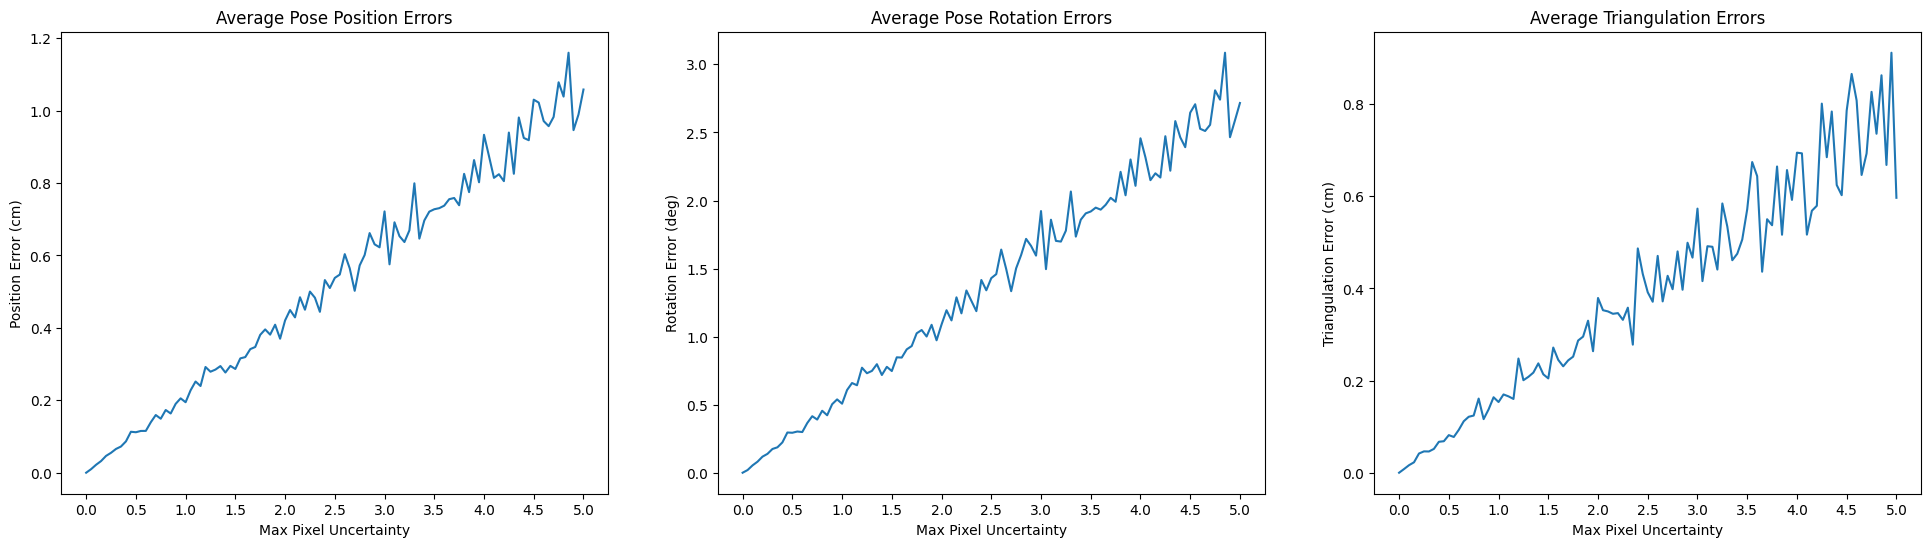

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(24,6))

xtick_labels = np.arange(0, largest_offset_pixels + largest_offset_pixels/n, largest_offset_pixels/n * 10)
xticks = xtick_labels * (n)/largest_offset_pixels

ax[0].set_title("Average Pose Position Errors")
ax[0].set_ylabel("Position Error (cm)")
ax[0].set_xlabel("Max Pixel Uncertainty")
ax[0].set_xticks(xticks, xtick_labels)
ax[0].plot(pose_position_errors)

ax[1].set_title("Average Pose Rotation Errors")
ax[1].set_ylabel("Rotation Error (deg)")
ax[1].set_xlabel("Max Pixel Uncertainty")
ax[1].set_xticks(xticks, xtick_labels)
ax[1].plot(pose_rotation_errors)

ax[2].set_title("Average Triangulation Errors")
ax[2].set_ylabel("Triangulation Error (cm)")
ax[2].set_xlabel("Max Pixel Uncertainty")
ax[2].set_xticks(xticks, xtick_labels)
ax[2].plot(average_triangulation_errors)

# fig.tight_layout()